In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib
# !pip install torchmetrics
# !pip install torch=='1.13.0'

In [34]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff
from src.projection_layers import LSTMMaskedAutoencoderProjection, MLPMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
ob_df_raw           = lumnis.get_historical_data("orderbook_snapshot_5", "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")


In [3]:
ob_df               = rolling_mean_diff(ob_df_raw, [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000], 'standard')

In [4]:
temp_df_btc         = rolling_mean_diff(temp_df_btc_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type='standard')
temp_df_eth         = rolling_mean_diff(temp_df_eth_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type='standard')
temp_df_xmr         = rolling_mean_diff(temp_df_xmr_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type='standard')


cols                = temp_df_btc.columns #['close', 'volume'] #
max_seq_len         = 50

btc_array           = create_3d_array(temp_df_btc[cols], temp_df_btc.index, max_seq_len)
eth_array           = create_3d_array(temp_df_eth[cols], temp_df_eth.index, max_seq_len)
xmr_array           = create_3d_array(temp_df_xmr[cols], temp_df_xmr.index, max_seq_len)

# x_data_f = fft.fft(torch.from_numpy( temp_df_btc.values )).abs()
# ( temp_df_btc_raw / temp_df_btc_raw.rolling(1000).max() )['volume'].plot()
# standardize(temp_df_btc, 500, type='standard')['close'].plot()

In [35]:
# Prepare your data as a dictionary
data_dict = {
    'dataset_btc': btc_array,
    'dataset_eth': eth_array,
    'dataset_xmr': xmr_array
}

data_dict['univariate'] = {"data": [], "labels": []}

for key in data_dict.keys():
    if key == 'univariate': continue

    num_points   = data_dict[key].shape[0]
    len_ts       = data_dict[key].shape[1]
    num_channels = data_dict[key].shape[2]

    for i in range(num_points - len_ts):
        for channel in range(num_channels):
            x = data_dict[key][i][:, channel]
            y = data_dict[key][i+len_ts][:, channel]
            
            x = np.expand_dims(x, axis=1)
            y = np.expand_dims(y, axis=1)

            data_dict['univariate']['data'].append(x)
            data_dict['univariate']['labels'].append(y)

data_dict['univariate']['data'] = np.array(data_dict['univariate']['data'])
data_dict['univariate']['labels'] = np.array(data_dict['univariate']['labels'])


for key in data_dict.keys():
    if key == 'univariate': 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
        
# Create instances of TSDataset for each dataset
datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len) if name=='univariate'
          else ImputationDataset(data)) for name, data in data_dict.items() }

# Create an instance of the custom data loader
ts_data_loader = TSDataLoader(datasets, batch_size=64, max_len=max_seq_len, collate_fn='unsuperv')

num_epochs = 4


In [36]:
ts_data_loader.data_loaders['univariate'].dataset

In [39]:
for epoch in range(num_epochs):
    for batch_data in ts_data_loader:
        for dataset_name, data in batch_data.items():
            
            ds_type = ts_data_loader.datasets[dataset_name]
            if isinstance(ds_type, ImputationDataset):
                inputs, targets, target_masks, padding_masks = data
                print(dataset_name, "inputs shape: ", inputs.shape, "targets shape: ", targets.shape, "target_masks shape: ", target_masks.shape, "padding_masks shape: ", padding_masks.shape)
            elif isinstance(ds_type, TSDataset):
                inputs, labels, padding_masks = data
                print(dataset_name, "inputs shape: ", inputs.shape, "labels shape: ", labels.shape, "padding_masks shape: ", padding_masks.shape)

            # print(dataset_name, inputs.shape)
            # print(dataset_name, inputs.shape, padding_masks.shape, targets.shape, target_masks.shape)
        break

dataset_eth inputs shape:  torch.Size([64, 50, 104]) targets shape:  torch.Size([64, 50, 104]) target_masks shape:  torch.Size([64, 50, 104]) padding_masks shape:  torch.Size([64, 50])
dataset_xmr inputs shape:  torch.Size([64, 50, 104]) targets shape:  torch.Size([64, 50, 104]) target_masks shape:  torch.Size([64, 50, 104]) padding_masks shape:  torch.Size([64, 50])
univariate inputs shape:  torch.Size([64, 50, 1]) labels shape:  torch.Size([64, 50, 1]) padding_masks shape:  torch.Size([64, 50])
dataset_btc inputs shape:  torch.Size([64, 50, 104]) targets shape:  torch.Size([64, 50, 104]) target_masks shape:  torch.Size([64, 50, 104]) padding_masks shape:  torch.Size([64, 50])


In [53]:
# Init parameters
input_dims  =  (50, 1)#btc_array.shape[1:]
hidden_dims = 16 
output_dims = 16 

# Create an instance of the model
# masked_ae = LSTMMaskedAutoencoderProjection(input_dims, hidden_dims, output_dims, device='cpu', use_revin=True, lose_type='masked_mse')
masked_ae =  MLPMaskedAutoencoderProjection(input_dims, hidden_dims, output_dims, device='cpu', use_revin=True, lose_type='masked_mse')

# Print the model summary
print( summary(masked_ae, (128,) + (50,1)) )

# Train the model
masked_ae.warmup(dataset=datasets['univariate'], max_len=max_seq_len, n_epochs=10, batch_size=1024, learning_rate=1e-3, log=True, data_set_type=type( datasets['univariate'] ), collate_fn='unsuperv')

Layer (type:depth-idx)                   Output Shape              Param #
MLPMaskedAutoencoderProjection           [128, 50, 1]              --
├─RevIN: 1-1                             [128, 50, 1]              100
├─Sequential: 1-2                        [128, 50, 16]             --
│    └─Linear: 2-1                       [128, 50, 16]             32
│    └─ReLU: 2-2                         [128, 50, 16]             --
│    └─Linear: 2-3                       [128, 50, 16]             272
├─Sequential: 1-3                        [128, 50, 1]              --
│    └─Linear: 2-4                       [128, 50, 16]             272
│    └─ReLU: 2-5                         [128, 50, 16]             --
│    └─Linear: 2-6                       [128, 50, 1]              17
├─RevIN: 1-4                             [128, 50, 1]              (recursive)
Total params: 693
Trainable params: 693
Non-trainable params: 0
Total mult-adds (M): 1.36
Input size (MB): 0.03
Forward/backward pass size (MB)

In [12]:
config_kwargs = {}
config_kwargs['batch_size']          = 128
config_kwargs['input_channels']      = data_dict['dataset_btc'].shape[-1]
config_kwargs['timesteps']           = data_dict['dataset_btc'].shape[1]
config_kwargs['TSlength_aligned']    = max_seq_len


configs = Configs(**config_kwargs)
labels = torch.zeros((data_dict['dataset_btc'].shape[0], 1))
ds = {"samples": data_dict['dataset_btc'], "labels": labels}

tfc_ds = TFCDataset(ds, configs, "pre_train", target_dataset_size=configs.batch_size, subset=False)


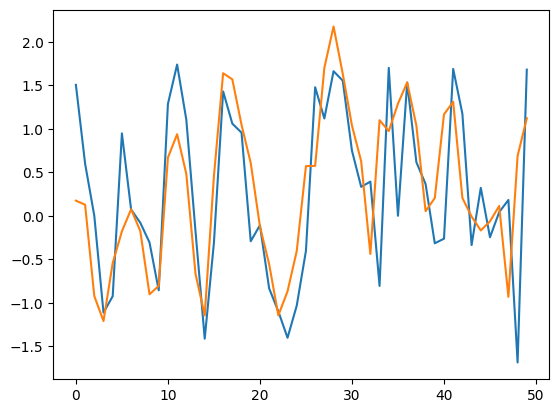

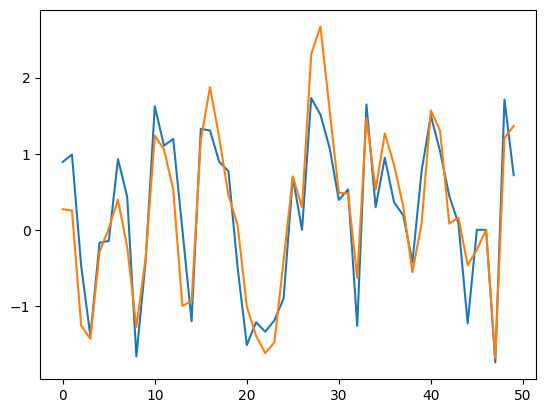

In [15]:
reconstructed_input = masked_ae(inputs, training=False)

channel  = 100
instance = 10

for channel in range(0, 2):
    plt.figure()
    plt.plot(inputs[instance][:,channel].detach().numpy()) 
    plt.plot(reconstructed_input[instance][:,channel].detach().numpy()) 

    plt.show()
    

embeddings = masked_ae.encode(inputs, type_of_pooling='mean')
# plt.plot( embeddings[:,2].detach().numpy() )

In [14]:
from src.encoders import TFC
configs = Configs(TSlength_aligned=50, 
                  features_len=inputs.shape[-1], 
                  features_len_f=inputs.shape[-1], 
                  n_head=1,
                  dim_feedforward=128,
                  num_transformer_layers=1,
                  encoder_layer_dims=128,
                  linear_encoder_dim=128,
                  channel_output_size=10,
                  time_output_size=10
                  )
tfc     = TFC(configs)

summary(tfc, ((64, 50, 104), (64, 50, 104), (64, 50)), dtypes=[torch.float32, torch.float32, torch.bool])

Layer (type:depth-idx)                             Output Shape              Param #
TFC                                                [64, 100]                 --
├─TSTransformerEncoder: 1-1                        [64, 50, 104]             --
│    └─Linear: 2-1                                 [50, 64, 128]             13,440
│    └─LearnablePositionalEncoding: 2-2            [50, 64, 128]             6,400
│    │    └─Dropout: 3-1                           [50, 64, 128]             --
│    └─TransformerEncoder: 2-3                     [50, 64, 128]             --
│    │    └─ModuleList: 3-2                        --                        99,584
│    └─Dropout: 2-4                                [64, 50, 128]             --
│    └─Linear: 2-5                                 [64, 50, 104]             13,416
├─Sequential: 1-2                                  [64, 100]                 --
│    └─AdaptiveAvgPool2d: 2-6                      [64, 10, 10]              --
│    └─Flatten: 2-7 

In [15]:
input_data_shapes_dict  = {name: data.shape[1:] for name, data in data_dict.items()}

encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=inputs.shape[-1], 
                                    features_len_f=inputs.shape[-1], 
                                    n_head=1,
                                    dim_feedforward=128,
                                    num_transformer_layers=1,
                                    encoder_layer_dims=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                )

tsfm                    = TSFM(input_data_shapes_dict, 
                                batch_size=1024, 
                                lr=1e-3, 
                                log=True, 
                                device='cpu',
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs
                                )

In [12]:
from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory

configs               =  encoder_configs
transformer_encoder_f = TSTransformerEncoder(configs.features_len, configs.TSlength_aligned, configs.d_model, configs.n_head,
                                configs.num_transformer_layers, configs.dim_feedforward, dropout=configs.dropout,
                                pos_encoding=configs.pos_encoding, activation=configs.transformer_activation,
                                norm=configs.transformer_normalization_layer, freeze=configs.freeze
                                )

In [13]:
# Create a two tensors of size (64, 50, 104) and  (64, 50) with dtypes torch.float32, torch.bool
x       = torch.randn(64, 50, 104)
mask    = torch.ones(64, 50, dtype=torch.bool)

# Pass the two tensors to the model
out     = transformer_encoder_f(x, mask)

In [ ]:
summary(transformer_encoder_f, ((64, 50, 104), (64, 50)), dtypes=[torch.float32, torch.bool])

Layer (type:depth-idx)                                  Output Shape              Param #
TSTransformerEncoder                                    [64, 50, 104]             --
├─Linear: 1-1                                           [50, 64, 128]             13,440
├─LearnablePositionalEncoding: 1-2                      [50, 64, 128]             6,400
│    └─Dropout: 2-1                                     [50, 64, 128]             --
├─TransformerEncoder: 1-3                               [50, 64, 128]             --
│    └─ModuleList: 2-2                                  --                        --
│    │    └─TransformerBatchNormEncoderLayer: 3-1       [50, 64, 128]             99,584
├─Dropout: 1-4                                          [64, 50, 128]             --
├─Linear: 1-5                                           [64, 50, 104]             13,416
Total params: 132,840
Trainable params: 132,840
Non-trainable params: 0
Total mult-adds (M): 3.21
Input size (MB): 1.33
Forward/ba

In [17]:
warmup_config_kwargs = {
    "dataset_btc": {
        "batch_size": 1024,
        "input_channels": data_dict['dataset_btc'].shape[-1],
        "timesteps": data_dict['dataset_btc'].shape[1],
    },
    "dataset_eth": {
        "batch_size": 1024,
        "input_channels": data_dict['dataset_eth'].shape[-1],
        "timesteps": data_dict['dataset_eth'].shape[1],
    },
    "dataset_xmr": {
        "batch_size": 1024,
        "input_channels": data_dict['dataset_xmr'].shape[-1],
        "timesteps": data_dict['dataset_xmr'].shape[1],
    }
}

data_set_type = ImputationDataset # Make the ability to infer dataset type based on projection layer 
loss          = tsfm.fit(data_dict, n_epochs=10, warmup_projection_layers=False, log=True, verbose=True, shuffle=True, warmup_epochs=10, warmup_config_kwargs=warmup_config_kwargs, warmup_batch_size=128, data_set_type=data_set_type)



/Users/abuj/Documents/GitHub/TS-FM/src/TSFM.py:133: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  train_data             = train_data[~np.isnan(train_data).all(axis=2).all(axis=1)]


In [ ]:
from src.loss import MASE
from torchmetrics import MeanAbsolutePercentageError, MeanSquaredLogError

loss_mse  = nn.MSELoss()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
loss_mape = nn.L1Loss()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
# loss_mase = MASE()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
loss_mape2 = MeanAbsolutePercentageError()(data_dict['dataset_btc'][3] , data_dict['dataset_btc'][100])
loss_msle = MeanSquaredLogError()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])


print(loss_mse, loss_mape, loss_mape2, loss_msle)

In [ ]:
config = {
    'task': 'imputation',
    'model': 'transformer',
    'num_layers': 2,
    'd_model': 32,
    'num_heads': 4,
    'dim_feedforward': 128,
    'dropout': 0.1,
    'pos_encoding': 'learnable',
    'activation': 'relu',
    'normalization_layer': 'layer_norm',
    'freeze': False,
    'data_window_len': max_seq_len,
    'max_seq_len': max_seq_len,
}
ts_model = model_factory(config, xmr_array.shape[-1])

# ts_model(xmr_array[0])